In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import BondGraphTools as bgt
import julia

# The cardiac Na+/K+ ATPase Bond Graph Model

In [2]:
# Reaction Conductance in fmol/s
reactions = [ 
    #reactants, products, rate
    (("P1",),("Ki","P2"), 330.5462), 
    (("P2",), ("Ki","P3",), 132850.9145),
    (("P3","Nai"), ("P4",), 200356.0223),
    (("P4","Nai"), ("P5",), 2238785.3951),
    (("P5","Nai"), ("P6", "zF_5"), 10787.9053),
    (("P6",), ("MgADP", "P7"), 15.3533),
    (("P7",),("P8",), 2.3882),
    (("P8",), ("P9", "Nae", "zF_8"), 2.2855),
    (("P9",), ("P10", "Nae"), 1540.1349),
    (("P10",),("P11","Nae"), 259461.6507),
    (("P11","Ke"), ("P12",), 172042.3334),
    (("P12","Ke"), ("P13",), 6646440.3909),
    (("P13",), ("P_i","H","P14"), 597.4136),
    (("P14","MgATP"),("P15",), 70.9823),
    (("P15",),("P1",), 0.015489)
]
     
# Chemical Affinities in 1/fmol
pump_affinities = [101619537.2009,
                  63209.8623,
                  157.2724,
                  14.0748,
                  5.0384,
                  92.6964,
                  4854.5924,
                  15260.9786,
                  13787022.8009,
                  20459.5509,
                  121.4556,
                  3.1436,
                  0.32549,
                  156.3283,
                  1977546.8577]

species_affinities = {
    "Ki":0.0012595,#intracellular potassium
    "Ke":0.009236, #extracelluar potassium
    "Nai":0.00083514,  #intracellular sodium
    "Nae":0.0061242,   #extracelluar sodium
    "MgATP": 2.3715,
    "MgADP": 7.976e-5,
    "P_i": 0.04565,
    "H": 0.04565
}

membrane_capacitance = 153400 #fentoFarad ?
F = 96485.33289 #faradays constant
r5_charge = -0.0550*F
r8_charge = -0.9450*F
Gas_Constant =  8.3144621
Temperature = 310

# Initial Conditions
initial_conditions = {
    "H": 0.0015128,
    "Ke": 27.9828,
    "Ki": 0.038,
    "MgADP": 0.038,
    "MgATP": 380,
    "Nae":777.3,
    "Nai":1900,
    "P_i": 0.038,
    "mem": -18408,
    "P1": 4.06727417747628e-10,
    "P2": 1.84495437200145e-09,
    "P3": 0.00183103460985586,
    "P4": 0.0324604777886237,
    "P5": 0.143884405731667,
    "P6": 0.00968432811008776,
    "P7": 0.534480003169437,
    "P8": 0.169644923453282,
    "P9": 5.63940980127252e-07,
    "P10": 7.9739635710452e-05,
    "P11": 0.00282186679243115,
    "P12": 0.0281498805518011,
    "P13": 0.0702590453291214,
    "P14": 0.00626267917464576,
    "P15": 0.000446049400255497
}

In [3]:
model = bgt.new(name="ATPase")
# add all the pumps
for pump, affinity in enumerate(pump_affinities):
    parameters = {'k':affinity,
                  'R':Gas_Constant,
                  'T':Temperature}
    name = "P{}".format(pump+1)
    Ce = bgt.new(component="Ce",
                 name=name,
                 library="BioChem",
                 value=parameters)
    junction = bgt.new("0", name=name)

    model.add(Ce, junction)
    model.connect(Ce, junction)

In [4]:
# add all the species
for species, affinity in species_affinities.items():
    parameters = {'k':affinity,
                  'R':Gas_Constant,
                  'T':Temperature}
    Ce = bgt.new(component="Ce",
                 name=species,
                 library="BioChem",
                 value=parameters)

    junction = bgt.new("0", name=species)
    model.add(Ce, junction)
    model.connect(Ce, junction)

In [5]:
#add the electrical components
c_mem = bgt.new('C',name="mem",value={'C':membrane_capacitance})
c_junction = bgt.new("0", name="mem")
model.add(c_mem, c_junction)
model.connect(c_mem, c_junction)

zF_5 = bgt.new('TF',name='zF_5', value={'r':r5_charge})
zF_8 = bgt.new('TF',name='zF_8', value={'r':r8_charge})

model.add(zF_5, zF_8)
port= 1 #  port 0 is the primary winding of a transformer and 1 is the secondary winding.
zF_5_secondary = (zF_5, port)  
zF_8_secondary = (zF_8, port) 
model.connect(zF_5_secondary, c_junction)
model.connect(zF_8_secondary, c_junction)

In [6]:
# add all the reactions and wire it up
for reaction_number, (reactants, products, rate) in enumerate(reactions):
    parameters  = {'r':rate, 'R':Gas_Constant, 'T':Temperature}
    name = "R{}".format(reaction_number+1)

    Re = bgt.new("Re", name=name, library="BioChem", value=parameters)
    model.add(Re)
    
    if len(reactants) > 1:
        in_port = bgt.new("Y", name=name+"_{in}",library="BioChem")
        model.add(in_port)
        model.connect((Re, 0), (in_port, 0))
        for reactant in reactants:
            junction = model.find(component="0", name=reactant)
            model.connect(junction, in_port)
    else:
        junction = model.find(component="0", name=reactants[0])
        model.connect((Re,0), junction)
        
    if len(products) > 1:
        out_port = bgt.new("Y", name=name+"_{out}",library="BioChem")
        model.add(out_port)
        model.connect((Re, 1), (out_port, 0))
        for product in products:
            if product == 'zF_5':
                junction = (zF_5, 0) # the primary winding of the charge transporter
            elif product == 'zF_8':
                junction = (zF_8, 0)
            else:
                junction = model.find(component="0", name=product)

            model.connect(junction, out_port)
    else:
        junction = model.find(component="0", name=products[0])
        model.connect((Re,1), junction)

<IPython.core.display.Javascript object>


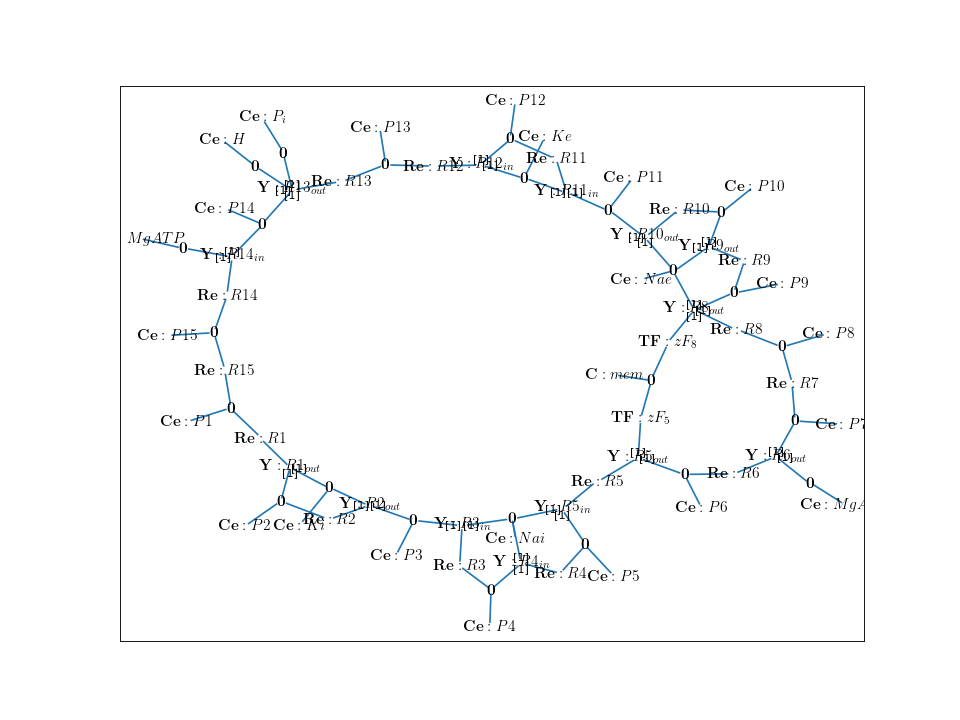

In [7]:
bgt.draw(model)

In [8]:
model.constitutive_relations

[dx_0 + 335915258525279*x_0/10000 - 263157156402003*x_1*x_15/10000000000 - 306302232789153*x_14/10000000000,
 dx_1 - 167949759337581*x_0/5000 + 263157156402003*x_1*x_15/10000000000 + 839748801197409*x_1/100000 - 52631437275171*x_15*x_2/2000000000,
 dx_2 - 839748801197409*x_1/100000 + 52631437275171*x_15*x_2/2000000000 + 263156559882621*x_17*x_2/10000000000 - 70499273566701*x_3/25000000,
 dx_3 - 263156559882621*x_17*x_2/10000000000 + 65789106977153*x_17*x_3/2500000000 + 70499273566701*x_3/25000000 - 56399481673359*x_4/5000000,
 dx_4 - 65789106977153*x_17*x_3/2500000000 + 2837063597033*x_17*x_4/62500000000 + 56399481673359*x_4/5000000 - 24999999621273*x_5*exp(-238300417828303*x_23/500000000000000000000000000)/25000000,
 dx_5 - 2837063597033*x_17*x_4/62500000000 - 594483291635481*x_20*x_6/100000000000000 + 35579890953*x_5/25000000 + 24999999621273*x_5*exp(-238300417828303*x_23/500000000000000000000000000)/25000000,
 dx_6 + 594483291635481*x_20*x_6/100000000000000 - 35579890953*x_5/2500000

In [8]:
from math import log
# Add Chemostats
for species, affinity in species_affinities.items():
    if species == "MgATP":
        effort = None
    else:
        effort = log(affinity*initial_conditions[species])
    Se = bgt.new('Se', value=effort, name=species)
    model.add(Se)
    junction = model.find(name=species, component='0')
    model.connect(Se, junction)

In [9]:
bgt.draw(model)

In [10]:
x0 = [v for k,v in initial_conditions.items()]
t,x = bgt.simulate(model, [0,1], x0, control_vars=[10])

First order control constriants not implemented: [-0.000163599141060906*exp(0.000387975363025938*u_0), 0]


SolverException: ('Integration error: Solver returned Unstable ', <PyCall.jlwrap retcode: Unstable
Interpolation: 3rd order Hermite
t: [0.0]
u: Array{Float64,1}[[0.0015128, 27.9828, 0.038, 0.038, 380.0, 777.3, 1900.0, 0.038, -18408.0, 4.06727e-10, 1.84495e-9, 0.00183103, 0.0324605, 0.143884, 0.00968433, 0.53448, 0.169645, 5.63941e-7, 7.97396e-5, 0.00282187, 0.0281499, 0.070259, 0.00626268, 0.000446049]]>)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
state_space, _, _ = model.basis_vectors
labels = [str(a) for a,_ in state_space.values()]
row, cols = x.shape
lines = []
for i in range(cols):
    plt.plot(t,x[:,i], label=labels[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.show()

In [ ]:
fif = plt.figure()
plt.plot(t,x[:,0])
fif.show()